In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from sklearn.metrics import roc_curve, roc_auc_score
from scipy import interpolate
from sklearn.utils import shuffle

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
from tensorflow.python.client import device_lib
physical_gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_gpus[0], True)

2024-07-25 13:53:44.536924: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2024-07-25 13:53:44.577209: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA TITAN Xp major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:3b:00.0
2024-07-25 13:53:44.577497: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2024-07-25 13:53:44.579338: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2024-07-25 13:53:44.580934: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2024-07-25 13:53:44.581316: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10.0
2024-07-25 13:53:44.583427: I tensorflow/stream_executor/platform/d

In [3]:
#Reading files into a log
import sys
import logging

nblog = open("nb_tl.log", "a+")
sys.stdout.echo = nblog
sys.stderr.echo = nblog

get_ipython().log.handlers[0].stream = nblog
get_ipython().log.setLevel(logging.INFO)

%autosave 5

Autosaving every 5 seconds


In [4]:
os.chdir(r'/home/manhducnmd/pp_dijet/Results_full')

In [5]:
np.random.seed(42)
tf.random.set_seed(42)

In [6]:
class ConvScaleShift(keras.layers.Layer):
    def __init__(self, channels, filters, kernel_size, trable = False, conv_trable = False, **kwargs):
        super(ConvScaleShift, self).__init__(**kwargs)
        self.conv = layers.Conv2D(filters, kernel_size, padding='same', trainable=conv_trable)

        self.shift = self.add_weight(name='shift', shape=(filters), 
                                     initializer='zeros', trainable=True)
        self.scale = self.add_weight(name='scale', shape=(1, 1, channels, filters), 
                                     initializer='ones', trainable=True)
        self.trable = trable
        self.act = keras.activations.relu
        
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'shift': self.shift,
            'scale': self.scale,
            'trable': self.trable,
            'act': self.act,
        })
        return config
    # Defines the computation
    def call(self, inputs):
        if self.trable == False:
            x = self.conv(inputs)
            x = self.act(x)
            return x
        else:
            y = self.conv(inputs)
            oldw = self.non_trainable_weights[-2]
            oldb = self.non_trainable_weights[-1]
            neww = tf.multiply(oldw, self.scale) 
            newb = tf.add(oldb, self.shift)
            x = tf.nn.conv2d(inputs, neww, strides = 1, padding='SAME') + newb            
            x = self.act(x)
            return x

In [7]:
#Defining the CWoLA model
def CWoLA(p_i, trable = False, conv_trable = False):
    
    input_1 = keras.layers.Input(shape = (p_i,p_i,1), name = "jet_1")
    y = keras.layers.BatchNormalization()(input_1)
    input_2 = keras.layers.Input(shape = (p_i,p_i,1), name = "jet_2")
    z = keras.layers.BatchNormalization()(input_2)
    
    cnn = keras.Sequential([
        ConvScaleShift(1 , 64, (5,5), trable = trable, conv_trable = conv_trable),
        keras.layers.MaxPool2D(pool_size = (2,2), trainable = conv_trable),
        ConvScaleShift(64, 64, (5,5), trable = trable),
        keras.layers.MaxPool2D(pool_size = (2,2), trainable = conv_trable),
        ConvScaleShift(64, 128, (3,3), trable = trable),
        keras.layers.MaxPool2D(pool_size = (2,2)),    
        ConvScaleShift(128, 128, (3,3), trable = trable, conv_trable = conv_trable),
        keras.layers.Flatten(),
    ])
        
    dnn = keras.Sequential([
          keras.layers.Dense(128, activation = 'relu'),
          keras.layers.Dense(128, activation = 'relu'),
          keras.layers.Dense(128, activation = 'relu'),
          keras.layers.Dense(1, activation = 'sigmoid')
    ])
    
    x_1 = dnn(cnn(y))
    x_2 = dnn(cnn(z))
    
    x = keras.layers.Multiply()([x_1, x_2])
    
    return keras.Model(         
    inputs=[input_1, input_2],
    outputs=x,)

In [8]:
# Extracting the data for pretraining
n_train_sr_bkg = 125000
n_train_sr_signal = 125000
files = ['id1', 'id5', 'id20', 'id30', 'id40', 'id50', 'dd1', 'dd5', 'id10', 'dd20', 
         'dd30', 'dd40', 'dd50'] #Notice that there is no dd10 file
rng = np.random.default_rng(seed=42)
for p_1 in [25]:#[25, 50, 75]:
    bkg_sr_jet_1 = np.load(f'm_background_images_sr_{p_1}_jet_1.npy')
    bkg_sr_jet_2 = np.load(f'm_background_images_sr_{p_1}_jet_2.npy')
    #First jet, background, SR
    bkg_train_1 = bkg_sr_jet_1[0:n_train_sr_bkg]
    #Second jet, background, SR
    bkg_train_2 = bkg_sr_jet_2[0:n_train_sr_bkg]
    
    bkg_train_1 = bkg_train_1.reshape((np.shape(bkg_train_1)[0], p_1, p_1, 1))
    bkg_train_2 = bkg_train_2.reshape((np.shape(bkg_train_2)[0], p_1, p_1, 1))
    bkg_train_label = np.zeros(np.shape(bkg_train_1)[0], dtype = int)
    
    signal_sr_jet_1_total = []
    signal_sr_jet_2_total = []
    for file in files:
        s1 = np.load(f'{file}_sr_{p_1}_jet_1.npy')[0:10000]
        s2 = np.load(f'{file}_sr_{p_1}_jet_2.npy')[0:10000]
        for idx, signal_sr_jet_1 in enumerate(s1): 
            signal_sr_jet_1_total.append(s1[idx])
            signal_sr_jet_2_total.append(s2[idx])
    signal_sr_jet_1_total = np.array(signal_sr_jet_1_total)
    signal_sr_jet_2_total = np.array(signal_sr_jet_2_total)
    
    signal_sr_jet_1_total = signal_sr_jet_1_total.reshape(np.shape(signal_sr_jet_1_total)[0], p_1, p_1, 1)
    signal_sr_jet_2_total = signal_sr_jet_2_total.reshape(np.shape(signal_sr_jet_2_total)[0], p_1, p_1, 1)
    
    
    indices = rng.permutation(np.shape(signal_sr_jet_1_total)[0])
    
    signal_sr_jet_1_total = signal_sr_jet_1_total[indices]
    signal_sr_jet_2_total = signal_sr_jet_2_total[indices]
    
    signal_train_1 = signal_sr_jet_1_total[0:n_train_sr_signal]
    signal_train_2 = signal_sr_jet_2_total[0:n_train_sr_signal]
    
    signal_train_label = np.ones(np.shape(signal_train_1)[0], dtype = int)
    
    x_train_1 = np.concatenate((signal_train_1, bkg_train_1))
    x_train_2 = np.concatenate((signal_train_2, bkg_train_2))
    y_train = np.concatenate((signal_train_label, bkg_train_label))
        
    #Mix up the samples
    indices_2 = rng.permutation(np.shape(y_train)[0])
        
    x_train_1 = x_train_1[indices_2]
    x_train_2 = x_train_2[indices_2]
    y_train = y_train[indices_2]    
    
    cwola = CWoLA(p_1, trable = False, conv_trable = True)
    loss_object = keras.losses.BinaryCrossentropy()
    optimizer = keras.optimizers.Adam(learning_rate = 1e-3)
    cwola.compile(loss = loss_object, optimizer = optimizer, metrics = ['accuracy'])
    cwola.save_weights(f'/home/manhducnmd/pp_dijet/Model_results/weights_pt_initial_dd10_{p_1}')
    early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=20, restore_best_weights=True)
    history = cwola.fit({'jet_1': x_train_1, 'jet_2': x_train_2}, y_train, validation_split = 0.2,
                        shuffle = True, batch_size = 500, callbacks = [early_stopping], epochs = 1000)  
    cwola.save_weights(f'/home/manhducnmd/pp_dijet/Model_results/weights_pt_dd10_{p_1}')

2024-07-25 13:54:16.017380: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
2024-07-25 13:54:16.052688: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3200000000 Hz
2024-07-25 13:54:16.054905: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5630a8807ff0 executing computations on platform Host. Devices:
2024-07-25 13:54:16.054949: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): Host, Default Version
2024-07-25 13:54:16.059193: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA TITAN Xp major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:3b:00.0
2024-07-25 13:54:16.059350: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2024-07-25 13:54:16.059396: I tensorflow/strea

Train on 200000 samples, validate on 50000 samples
Epoch 1/1000


2024-07-25 13:54:19.533459: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2024-07-25 13:54:19.692921: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2024-07-25 13:54:20.216857: W tensorflow/stream_executor/cuda/redzone_allocator.cc:312] Not found: ./bin/ptxas not found
Relying on driver to perform ptx compilation. This message will be only logged once.


200000/200000 [==============================] - 12s 62us/sample - loss: 0.3215 - accuracy: 0.8607 - val_loss: 0.2658 - val_accuracy: 0.8870
Epoch 2/1000
200000/200000 [==============================] - 13s 67us/sample - loss: 0.2705 - accuracy: 0.8862 - val_loss: 0.2680 - val_accuracy: 0.8881
Epoch 3/1000
200000/200000 [==============================] - 15s 76us/sample - loss: 0.2622 - accuracy: 0.8893 - val_loss: 0.2529 - val_accuracy: 0.8946
Epoch 4/1000
200000/200000 [==============================] - 15s 76us/sample - loss: 0.2600 - accuracy: 0.8907 - val_loss: 0.2496 - val_accuracy: 0.8956
Epoch 5/1000
200000/200000 [==============================] - 15s 76us/sample - loss: 0.2569 - accuracy: 0.8917 - val_loss: 0.2493 - val_accuracy: 0.8948
Epoch 6/1000
200000/200000 [==============================] - 15s 76us/sample - loss: 0.2567 - accuracy: 0.8918 - val_loss: 0.2465 - val_accuracy: 0.8956
Epoch 7/1000
200000/200000 [==============================] - 15s 75us/sample - loss: 0.2

Epoch 54/1000
200000/200000 [==============================] - 11s 53us/sample - loss: 0.2232 - accuracy: 0.9051 - val_loss: 0.2442 - val_accuracy: 0.8991
Epoch 55/1000
200000/200000 [==============================] - 11s 53us/sample - loss: 0.2213 - accuracy: 0.9062 - val_loss: 0.2423 - val_accuracy: 0.8981
Epoch 56/1000
200000/200000 [==============================] - 11s 53us/sample - loss: 0.2206 - accuracy: 0.9062 - val_loss: 0.2497 - val_accuracy: 0.8961
Epoch 57/1000
200000/200000 [==============================] - 11s 53us/sample - loss: 0.2201 - accuracy: 0.9062 - val_loss: 0.2417 - val_accuracy: 0.8993
Epoch 58/1000
200000/200000 [==============================] - 11s 53us/sample - loss: 0.2184 - accuracy: 0.9067 - val_loss: 0.2535 - val_accuracy: 0.8943
Epoch 59/1000
200000/200000 [==============================] - 10s 52us/sample - loss: 0.2201 - accuracy: 0.9059 - val_loss: 0.2515 - val_accuracy: 0.8982
Epoch 60/1000
200000/200000 [==============================] - 11s 53u

In [9]:
cwola.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
jet_1 (InputLayer)              [(None, 75, 75, 1)]  0                                            
__________________________________________________________________________________________________
jet_2 (InputLayer)              [(None, 75, 75, 1)]  0                                            
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 75, 75, 1)    4           jet_1[0][0]                      
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 75, 75, 1)    4           jet_2[0][0]                      
____________________________________________________________________________________________

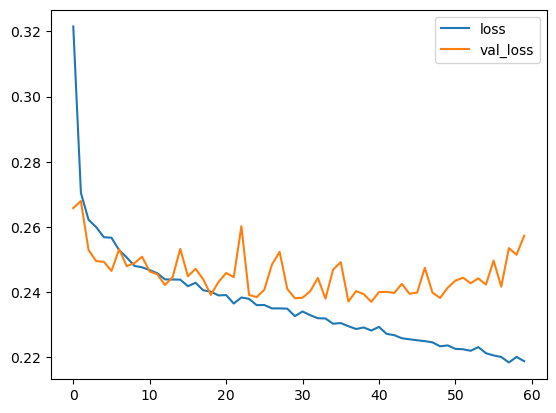

In [9]:
plt.figure()
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend(loc = 'upper right')
plt.show()

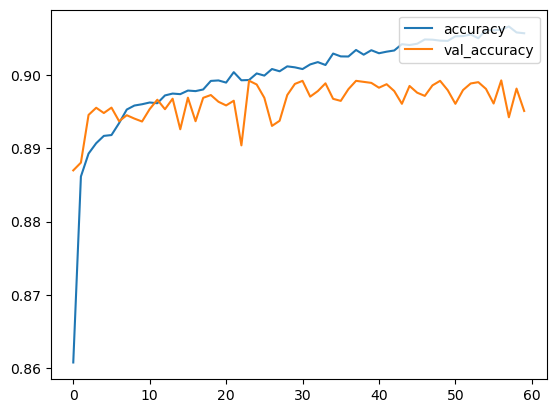

In [10]:
plt.figure()
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.legend(loc = 'upper right')
plt.show()

In [14]:
new_cwola = CWoLA(25, trable = True)
new_cwola.load_weights(f'/home/manhducnmd/pp_dijet/Model_results/weights_pt_initial_dd10_{p_1}')


In [15]:
new_cwola.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
jet_1 (InputLayer)              [(None, 25, 25, 1)]  0                                            
__________________________________________________________________________________________________
jet_2 (InputLayer)              [(None, 25, 25, 1)]  0                                            
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 25, 25, 1)    4           jet_1[0][0]                      
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 25, 25, 1)    4           jet_2[0][0]                      
____________________________________________________________________________________________

In [11]:
os.chdir('/home/manhducnmd/pp_dijet/Model_results')

In [168]:
loaded_model = keras.models.load_model('pt_dd10_25.keras')

In [ ]:
initial_model = keras.models.load_model('pt_initial_dd10_25.keras')

In [170]:
os.chdir(r'/home/manhducnmd/pp_dijet/Results_full')

In [171]:
loaded_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
jet_1 (InputLayer)              [(None, 25, 25, 1)]  0                                            
__________________________________________________________________________________________________
jet_2 (InputLayer)              [(None, 25, 25, 1)]  0                                            
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 25, 25, 1)    4           jet_1[0][0]                      
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 25, 25, 1)    4           jet_2[0][0]                      
____________________________________________________________________________________________

In [172]:
loaded_model.trainable = False

In [11]:
print(cwola.layers[4].weights)

[<tf.Variable 'shift:0' shape=(64,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'scale:0' shape=(1, 1, 1, 64) dtype=float32, numpy=
array([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1.]]]], dtype=float32)>, <tf.Variable 'sequential/conv_scale_shift/conv2d/kernel:0' shape=(5, 5, 1, 64) dtype=float32, numpy=
array([[[[ 2.84967553e-02, -3.38603333e-02, -4.25574303e-01, ...,
          -4.99012768e-02, -8.56027529e-02,  4.13369983e-02]],

        [[ 4.0201

In [12]:
print(cwola.layers[5].weights)

[<tf.Variable 'sequential_1/dense/kernel:0' shape=(1152, 128) dtype=float32, numpy=
array([[ 0.04151135, -0.00620119, -0.0233185 , ..., -0.02594103,
        -0.01549602, -0.01261508],
       [ 0.0191442 ,  0.04920241,  0.01929851, ...,  0.01122847,
         0.05543187, -0.04479811],
       [-0.05536358,  0.05782972,  0.04008048, ..., -0.00080706,
        -0.05056986, -0.01152387],
       ...,
       [ 0.03275909, -0.01805449, -0.06720076, ..., -0.04711647,
         0.03725545,  0.01011571],
       [ 0.07183843,  0.00203153, -0.02572582, ..., -0.03255004,
         0.01485772,  0.08039683],
       [-0.05666127,  0.07008833, -0.03212228, ...,  0.01861471,
         0.00681008,  0.01668436]], dtype=float32)>, <tf.Variable 'sequential_1/dense/bias:0' shape=(128,) dtype=float32, numpy=
array([-0.00106248, -0.027414  , -0.02101066, -0.0418516 , -0.03346669,
       -0.06270102, -0.05120459, -0.01011984, -0.00281157, -0.06285948,
        0.01718352, -0.05590101, -0.02259405, -0.09440721, -0.0711

In [2]:
initial_weights = initial_model.layers[5].get_weights()
loaded_model.layers[5].set_weights(initial_weights)

NameError: name 'initial_model' is not defined

In [176]:
print(loaded_model.layers[5].weights[0])

<tf.Variable 'sequential_5_9/dense_8/kernel:0' shape=(1152, 128) dtype=float32, numpy=
array([[ 0.04151135, -0.00030435, -0.01772699, ..., -0.02740256,
        -0.02138304, -0.01782336],
       [ 0.04094961,  0.05507887,  0.02192558, ...,  0.01142774,
         0.06550565, -0.03992231],
       [-0.06440324,  0.0638316 ,  0.04577684, ...,  0.00208545,
        -0.05588841, -0.01210831],
       ...,
       [ 0.0307514 , -0.01207008, -0.06143984, ..., -0.04826026,
         0.03134148,  0.00919251],
       [ 0.05978832,  0.00203153, -0.02276526, ..., -0.03255004,
        -0.03657148,  0.01606582],
       [-0.05766067,  0.06299955, -0.0452524 , ...,  0.05907474,
        -0.00846294,  0.00063005]], dtype=float32)>


In [26]:
#Fine-tuning on data
n_train_sr_bkg = 50000
n_train_sr_bkg_ft = 25000
mean_results = []
std_results = []
n_test_sr_bkg = 20000
for p_1 in [25]:#[25,50,75]:
    rng = np.random.default_rng(seed=42)
    os.chdir('/home/manhducnmd/pp_dijet/Model_results')    
    loaded_model = CWoLA(p_1, trable = False, conv_trable = False)   
    redundant_model = CWoLA(p_1, trable = False, conv_trable = False)
    loaded_model.load_weights(f'weights_pt_dd10_{p_1}') 
    #redundant_model.load_weights(f'weights_pt_initial_id5_{p_1}') 
    loaded_model.layers[5].set_weights(redundant_model.layers[5].get_weights())    
    os.chdir(r'/home/manhducnmd/pp_dijet/Results_full')   
    
    bkg_sr_jet_1 = np.load(f'background_images_sr_{p_1}_jet_1.npy')
    bkg_sr_jet_2 = np.load(f'background_images_sr_{p_1}_jet_2.npy')
    
    bkg_sb_jet_1 = np.load(f'background_images_sb_{p_1}_jet_1.npy')
    bkg_sb_jet_2 = np.load(f'background_images_sb_{p_1}_jet_2.npy')
    
    sb_sr_bkg = np.shape(bkg_sb_jet_1)[0]/np.shape(bkg_sr_jet_2)[0]
    n_train_sb_bkg_ft = int(np.round(n_train_sr_bkg_ft*sb_sr_bkg))
    #First jet, background, SR
    bkg_pretrain_sr_1 = bkg_sr_jet_1[0:-n_test_sr_bkg]
    #Second jet, background, SR
    bkg_pretrain_sr_2 = bkg_sr_jet_2[0:-n_test_sr_bkg]
    #First jet, background, SB
    bkg_pretrain_sb_1 = bkg_sb_jet_1[0:-n_test_sr_bkg]
    #Second jet, background, SB
    bkg_pretrain_sb_2 = bkg_sb_jet_2[0:-n_test_sr_bkg]
    
    signal_sr_jet_1 = np.load(f'dd10_sr_{p_1}_jet_1.npy')
    signal_sr_jet_2 = np.load(f'dd10_sr_{p_1}_jet_2.npy')
    
    signal_sb_jet_1 = np.load(f'dd10_sb_{p_1}_jet_1.npy')
    signal_sb_jet_2 = np.load(f'dd10_sb_{p_1}_jet_2.npy')
    
    sb_sr_signal = np.shape(signal_sb_jet_1)[0]/np.shape(signal_sr_jet_1)[0]
    for n_train_sr_signal in [1200]:#[50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800, 900, 1000, 1100, 1200]:
        significance = np.sqrt(2*((n_train_sr_signal+25000)*np.log(n_train_sr_signal/25000 + 1) - n_train_sr_signal))
        
        n_train_sb_signal = int(np.round(n_train_sr_signal*sb_sr_signal))
        n_test_sr_signal = 20000
        
        #First jet, signal, SR
        signal_pretrain_sr_1 = signal_sr_jet_1[0:20000]
        
        #Second jet, signal, SR
        signal_pretrain_sr_2 = signal_sr_jet_2[0:20000]

        #First jet, signal, SB
        signal_pretrain_sb_1 = signal_sb_jet_1[0:20000]

        #Second jet, signal, SB
        signal_pretrain_sb_2 = signal_sb_jet_2[0:20000]
        
        rng_2 = np.random.default_rng(seed=42)
        rng_3 = np.random.default_rng(seed=42)

        for i in range(1):
            indices_2 = rng_2.permutation(np.shape(bkg_pretrain_sr_1)[0])
            indices_3 = rng_3.permutation(np.shape(signal_pretrain_sr_1)[0])
            
            #First jet, background, SR
            bkg_train_sr_1 = (bkg_pretrain_sr_1[indices_2])[0:n_train_sr_bkg_ft]
            #Second jet, background, SR
            bkg_train_sr_2 = (bkg_pretrain_sr_2[indices_2])[0:n_train_sr_bkg_ft]
            #First jet, background, SB
            bkg_train_sb_1 = (bkg_pretrain_sb_1[indices_2])[0:n_train_sb_bkg_ft]
            #Second jet, background, SB
            bkg_train_sb_2 = (bkg_pretrain_sb_2[indices_2])[0:n_train_sb_bkg_ft]

            signal_train_sr_1 = (signal_pretrain_sr_1[indices_3])[0:n_train_sr_signal]
            #Second jet, background, SR
            signal_train_sr_2 = (signal_pretrain_sr_2[indices_3])[0:n_train_sr_signal]
            #First jet, background, SB
            signal_train_sb_1 = (signal_pretrain_sb_1[indices_3])[0:n_train_sb_signal]
            #Second jet, background, SB
            signal_train_sb_2 = (signal_pretrain_sb_2[indices_3])[0:n_train_sb_signal]

            train_sr_1 = np.concatenate((signal_train_sr_1, bkg_train_sr_1))
            train_sr_2 = np.concatenate((signal_train_sr_2, bkg_train_sr_2))
            train_label_sr = np.ones(np.shape(train_sr_1)[0], dtype = int)

            train_sb_1 = np.concatenate((signal_train_sb_1, bkg_train_sb_1))
            train_sb_2 = np.concatenate((signal_train_sb_2, bkg_train_sb_2))
            train_label_sb = np.zeros(np.shape(train_sb_1)[0], dtype = int)

            x_train_1 = np.concatenate((train_sr_1, train_sb_1))
            x_train_2 = np.concatenate((train_sr_2, train_sb_2))
            y_train = np.concatenate((train_label_sr, train_label_sb))

            #Mix up the samples
            indices = rng.permutation(np.shape(y_train)[0])
            x_train_1 = x_train_1[indices]
            x_train_2 = x_train_2[indices]
            y_train = y_train[indices]

            x_train_1 = x_train_1.reshape((np.shape(x_train_1)[0], p_1, p_1, 1))
            x_train_2 = x_train_2.reshape((np.shape(x_train_2)[0], p_1, p_1, 1))

            print(f'Training with significance = {significance:.2f}, run {i}')
            cwola_ft = CWoLA(p_1, trable = False, conv_trable = False)
            cwola_ft.set_weights(loaded_model.get_weights())
            cwola_ft.trainable = True
            cwola_ft.layers[4].trainable = False #Freezing the 4th layer            
            loss_object = keras.losses.BinaryCrossentropy()
            optimizer = keras.optimizers.Adam(learning_rate = 1e-4)
            cwola_ft.compile(loss = loss_object, optimizer = optimizer, metrics = ['accuracy'])
            early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=30, restore_best_weights=True)
            history = cwola_ft.fit({'jet_1': x_train_1, 'jet_2': x_train_2}, y_train, validation_split = 0.2,
              shuffle = True, batch_size = 500, callbacks = [early_stopping], epochs = 1000)  
            #cwola_ft.save_weights(f'/home/manhducnmd/pp_dijet/Model_results/run_{i}_weights_ft_dd10_{n_train_sr_signal}_{p_1}')            
    

Training with significance = 7.53, run 0
Train on 41504 samples, validate on 10376 samples
Epoch 1/1000
41504/41504 [==============================] - 3s 73us/sample - loss: 0.7168 - accuracy: 0.5099 - val_loss: 0.6970 - val_accuracy: 0.5032
Epoch 2/1000
41504/41504 [==============================] - 2s 48us/sample - loss: 0.6939 - accuracy: 0.5122 - val_loss: 0.6938 - val_accuracy: 0.5107
Epoch 3/1000
41504/41504 [==============================] - 2s 49us/sample - loss: 0.6924 - accuracy: 0.5166 - val_loss: 0.6934 - val_accuracy: 0.5089
Epoch 4/1000
41504/41504 [==============================] - 2s 48us/sample - loss: 0.6923 - accuracy: 0.5169 - val_loss: 0.6935 - val_accuracy: 0.5096
Epoch 5/1000
41504/41504 [==============================] - 2s 48us/sample - loss: 0.6919 - accuracy: 0.5183 - val_loss: 0.6928 - val_accuracy: 0.5098
Epoch 6/1000
41504/41504 [==============================] - 2s 49us/sample - loss: 0.6918 - accuracy: 0.5186 - val_loss: 0.6927 - val_accuracy: 0.5094
Epo

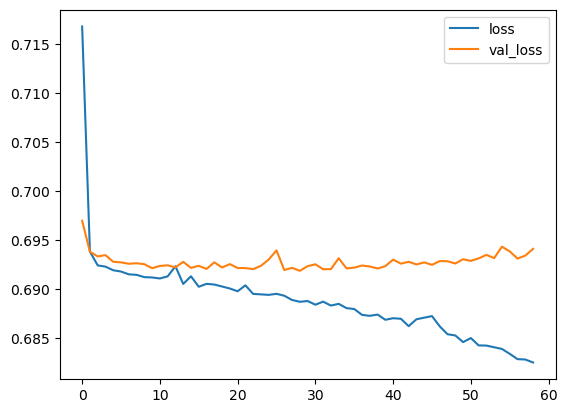

In [27]:
plt.figure()
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend(loc = 'upper right')
plt.show()

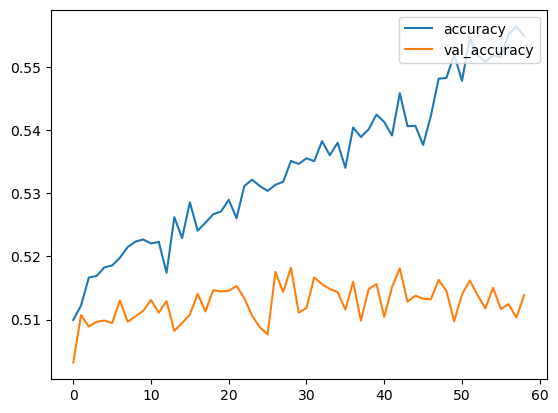

In [28]:
plt.figure()
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.legend(loc = 'upper right')
plt.show()

In [29]:
os.chdir(r'/home/manhducnmd/pp_dijet/Results_full')

In [30]:
bkg_sr_jet_1 = np.load('background_images_sr_25_jet_1.npy')
bkg_sr_jet_2 = np.load('background_images_sr_25_jet_2.npy')

signal_sr_jet_1 = np.load('id5_sr_25_jet_1.npy')
signal_sr_jet_2 = np.load('id5_sr_25_jet_2.npy')



In [31]:
signal_test_1 = signal_sr_jet_1[-20000:]
signal_test_2 = signal_sr_jet_2[-20000:]

bkg_test_1 = bkg_sr_jet_1[-20000:]
bkg_test_2 = bkg_sr_jet_2[-20000:]


test_label_signal = np.ones(np.shape(signal_test_1)[0])
test_label_bkg = np.zeros(np.shape(bkg_test_1)[0])

x_test_1 = np.concatenate((signal_test_1, bkg_test_1))
x_test_2 = np.concatenate((signal_test_2, bkg_test_2))
y_test = np.concatenate((test_label_signal, test_label_bkg))

x_test_1 = x_test_1.reshape((np.shape(x_test_1)[0],25,25,1))
x_test_2 = x_test_2.reshape((np.shape(x_test_2)[0],25,25,1))


In [32]:
x_predict = cwola_ft.predict([x_test_1, x_test_2])


In [33]:
x_predict_0 = x_predict[y_test == 0]
x_predict_1 = x_predict[y_test == 1]

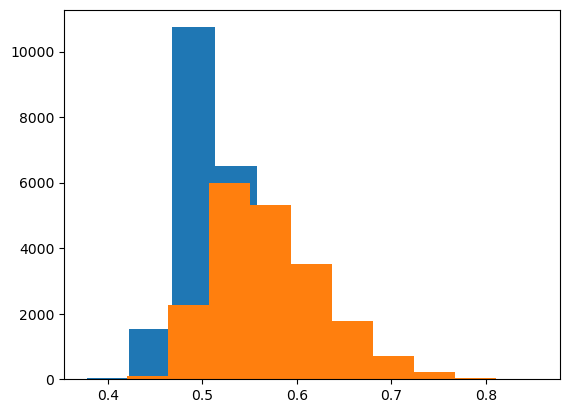

In [34]:
plt.hist(x_predict_0)
plt.hist(x_predict_1)
plt.show()

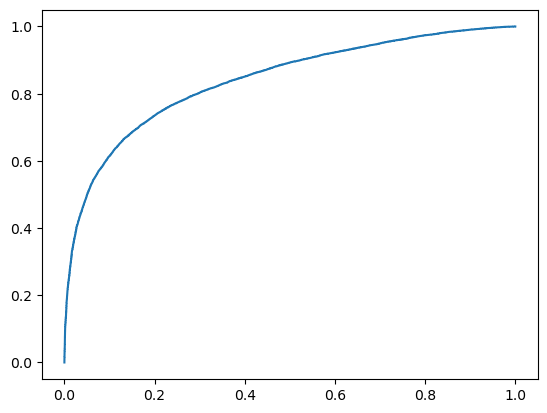

0.83983900125


In [35]:
fpr, tpr, th = roc_curve(y_test, x_predict)
plt.plot(fpr, tpr)
plt.show()
f = interpolate.interp1d(fpr, tpr)
epsilon_s = f([0.001, 0.01, 0.1])
print(roc_auc_score(y_test, x_predict))

In [22]:
print(cwola_ft.layers[4].weights)

[<tf.Variable 'shift:0' shape=(64,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'scale:0' shape=(1, 1, 1, 64) dtype=float32, numpy=
array([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1.]]]], dtype=float32)>, <tf.Variable 'sequential_10/conv_scale_shift_20/conv2d_20/kernel:0' shape=(5, 5, 1, 64) dtype=float32, numpy=
array([[[[ 5.49082235e-02, -1.81777403e-01, -6.04940116e-01, ...,
          -6.49320707e-02, -1.11150660e-01,  4.05093059e-02]],

        

In [23]:
print(cwola_ft.layers[5].weights)

[<tf.Variable 'sequential_11/dense_20/kernel:0' shape=(1152, 128) dtype=float32, numpy=
array([[ 0.04151135, -0.00030435, -0.01772699, ..., -0.02740256,
        -0.02138304, -0.01782336],
       [ 0.04094961,  0.05507887,  0.02192558, ...,  0.01142774,
         0.06550565, -0.03992231],
       [-0.06440324,  0.0638316 ,  0.04577684, ...,  0.00208545,
        -0.05588841, -0.01210831],
       ...,
       [ 0.0307514 , -0.01207008, -0.06143984, ..., -0.04826026,
         0.03134148,  0.00919251],
       [ 0.05978832,  0.00203153, -0.02276526, ..., -0.03255004,
        -0.03657148,  0.01606582],
       [-0.06247181,  0.06299955, -0.05493616, ...,  0.05907474,
        -0.01267925, -0.01038713]], dtype=float32)>, <tf.Variable 'sequential_11/dense_20/bias:0' shape=(128,) dtype=float32, numpy=
array([-0.00124089, -0.00361401, -0.00364657,  0.0038098 ,  0.012067  ,
        0.01119462,  0.0100122 , -0.00152189,  0.01090805,  0.00398525,
       -0.00488884,  0.0104038 ,  0.01064777, -0.00359594,

In [36]:
print(epsilon_s)

[0.06215 0.25075 0.6145 ]


In [37]:
n_train_sr_signal = 1200

In [38]:
print(np.sqrt(2*((n_train_sr_signal*epsilon_s[1]+25000*0.01)*np.log(n_train_sr_signal*epsilon_s[1]/(25000*0.01) + 1) - 
                 n_train_sr_signal*epsilon_s[1])))

16.39279694176611
